This notebook uses **pre-trained models** to explore what can be done with sketch-RNN. 

In [1]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [2]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)
# tells which version of tensorflow is being used


INFO:tensorflow:TensorFlow Version: 1.1.0


In [3]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [4]:
# this function displays vector images, and saves them to .svg
# you can invoke the "draw_strokes" function anytime you want to render an image -
# specify source, destination filename, and random scale factor (defaults below) 

def draw_strokes(data, svg_filename = 'sample.svg', factor=0.2):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [5]:
#these global variables define the relative path to the model and dataset being used
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
models_root_dir = '/tmp/sketch_rnn/models'
model_dir = '/tmp/sketch_rnn/models/aaron_sheep/layer_norm'

In [6]:
#run this if you want to use the demo models from magenta
download_pretrained_models(models_root_dir=models_root_dir)

INFO:tensorflow:/tmp/sketch_rnn/models/sketch_rnn.zip already exists, using cached copy
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


In [7]:
#populates the above global variables throughout the sketch_rnn project files
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [8]:
#construct the sketch-rnn model:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.


In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


# Encode and Decode Sample Drawings
First, define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke:

In [11]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [12]:
def decode(z_input=None, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  return strokes

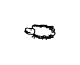

In [13]:
# get a sample drawing from the test set, and render it to .svg
example_drawing = test_set.random_sample()
draw_strokes(example_drawing)

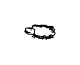

In [14]:
#encode the sample drawing into latent vector z
z = encode(example_drawing)

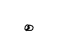

In [15]:
# convert z back to drawing, using a "temperature" of 0.1
decoded_drawing = decode(z, temperature=0.1) 
draw_strokes(decoded_drawing, 'sample3.svg', 0.2) 
#specify the input source, the filename to save to (in the same directory as this notebook), and the random scale factor (default is 0.2), and 

# Temperature Interpolation

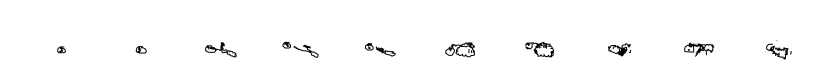

In [16]:
#Create a series of drawings stepping through various "temperatures" from 0.1 to 1.0
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid, 'sample-interp-temp.svg') #if two arguments are given to draw_strokes, they are input vector and output filename

# Latent Space Interpolation 
Stepping through latent space between two sample images ($z_0$ and $z_1$)

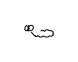

In [17]:
#z0 is the first sample
z0 = z #use the random sample we'd already  selected
decoded_drawing = decode(z0)
#each time it's decoded from the latent vector it's slightly different
draw_strokes(decoded_drawing)
#uses default file destination of 'sample.svg' and default random scale factor of 0.2

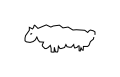

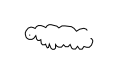

In [18]:
#z1 is the second sample
z1 = encode(test_set.random_sample()) #grab a new random sample and encode it
decoded_drawing2 = decode(z1) #then decode it 
draw_strokes(decoded_drawing2)
#the top drawing is the encoded version, the bottom is the decoded version

In [19]:
z_list = [] # interpolate spherically between z0 and z1
N = 10 # change this number to add more steps
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [20]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i]), [0, i]])

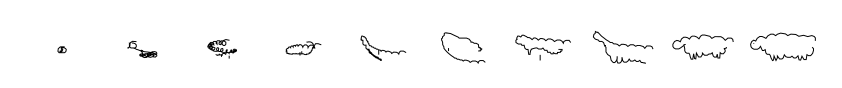

In [21]:
#draw the interpolation steps
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid, 'sample-interp1.svg') 

# Unconditional (Decoder-Only) Generation

In [22]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'

In [23]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)

In [24]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.


In [25]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [26]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/flamingo/lstm_uncond/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/flamingo/lstm_uncond/vector


In [28]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.1), [0, i]])
#experiment with different temperature values to get more variety

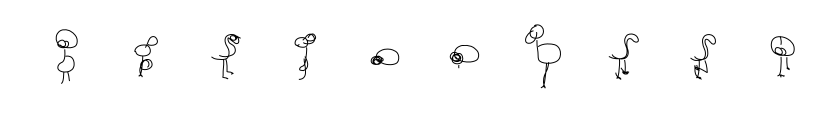

In [29]:
#draw 10 examples
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

# Generate sketches using random IID gaussian latent vectors

In [30]:
#other models available:
#model_dir = '/tmp/sketch_rnn/models/owl/lstm'
#model_dir = '/tmp/sketch_rnn/models/catbus/lstm'
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [31]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/elephantpig/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/elephantpig/lstm/vector


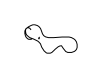

In [32]:
#randomly select a latent vector z_0
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)
draw_strokes(_)

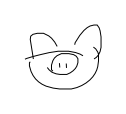

In [33]:
#randomly select a second vector z_1
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)
draw_strokes(_)

In [34]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], temperature=0.1), [0, i]])

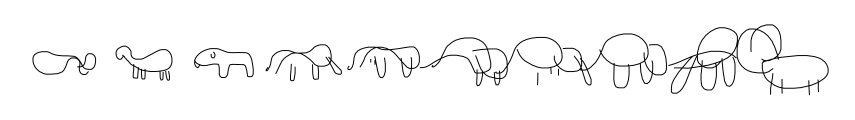

In [35]:
#draw the interpolation
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid, 'sample-interp2.svg')